In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Introduction
Thermocouples are widely used for temperature sensors in the automotive industry for measurement of exhaust gas temperature. One of the most suitable thermocouple type is type N. Typical sensor is made from probe, flexible cable and electronics. A pair of solid leads is inserted in the probe. The signal is conducted to the electronics by the flexible wires, which are again type N thermocouple. This is needed to create cold junction close to the electronics, where RTD sensor is used to measure the cold junction temperature. Type N thermocouples are delivered according standards, defining their accuracy. The sensor accuracy depends on the accuracy of the leads pair, flexible wire pair and the electronics. The following project demonstrates how the accuracy of leads and wires are combined using Monte Carlo algorithm. There are several complications that make simpler methods not applicable: the temperature of the weld between leads and wires is not known; the generated voltage is not linearly proportional to the temperature difference; leads and wires are made from different batches and their electromotive force is not equal.
![title](DTC.png)

In this study both leads and wires are delivered according ASTM E230 Type N thermo couple with accuracy class 1. The functions below define the accuracy.

In [48]:
def leads_accuracy(Thot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the maximum acceptable deviation in °C
    It is assumed the lead supplier delivers TC pairs within the acceptable interval 
    with 3 sigma confidence (99.7%;Ppk = 1)
    """
    if Thot >= 0:
        return np.maximum(1.1, 0.004 * Thot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")

def wires_accuracy(Thot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the maximum acceptable deviation in °C
    It is assumed the wire supplier delivers TC pairs within the acceptable interval 
    with 3 sigma confidence (99.7%;Ppk = 1)
    """
    if Thot >= 0:
        return np.maximum(1.1, 0.004 * Thot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")


Let's plot the limits.

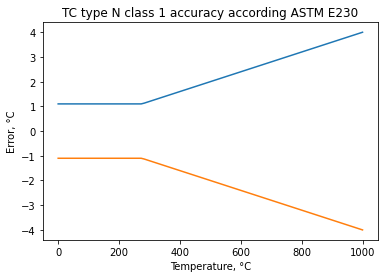

In [53]:
x_values = np.linspace(0, 1000, 100)
y_values = np.vectorize(leads_accuracy)(x_values)
plt.plot(x_values, y_values)
plt.plot(x_values, -y_values)

plt.title("TC type N class 1 accuracy according ASTM E230")
plt.xlabel("Temperature, °C")
plt.ylabel("Error, °C")
plt.show()

It is important to note that any curve within the limits defined above is acceptable. It is possible some TC batch to show curve strating from the lower psecification limit (LSL) goes up to upper specification limit (USL) and then goes down to LSL.

In order to make the transformations from the generated voltage to temperature and reverse, we need to define functions for the nominal transformation. These functions are polynoms, also defined in ASTM E230. The polynom coeficents depends on the voltage of interest.

In [54]:
def temperature_typeN(emf):
    """
    acc ASTM E230, table 46 TYPE N Thermocouple
    E is the thermocouple emf in mV
    returns in °C
    """
    
     #the last is the free coeficent
    poly1 = np.poly1d([0.0073138868, 0.11582665, 0.77075166, 2.7754916, 5.8488586, 7.2060525, 5.2229312, 1.1010485, 38.436847,0])
    poly2 = np.poly1d([-0.0000000798156, 0.0000053928, -0.000117272, -0.00000212169, 0.0470205, -1.08267, 38.6896, 0]) 
    poly3 = np.poly1d([0.0000007767022, -0.0001274371, 0.009855391, -0.3915159, 33.00943, 19.72485]) 
    
    if -3.99 <= emf < 0:
        return poly1(emf)
    elif 0 <= emf < 20.613:
        return poly2(emf)
    elif 20.613 <= emf <= 47.513:
        return poly3(emf)
    else:
        raise ValueError("EMF outside specified range")

# print(temperature_typeN(-2))
# print(temperature_typeN(10))
# print(temperature_typeN(30))

def emf_typeN(t):
    """
    acc ASTM E230, 
    t is the thermocouple hot junction temperature in °C
    returns in mv
    """
    pass

Let's plot the relation between electromotive force (EMF) and temperature:

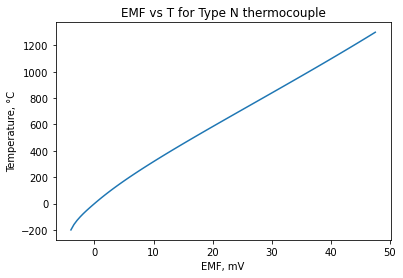

In [55]:
x_values = np.linspace(-3.99, 47.513, 100)
y_values = np.vectorize(temperature_typeN)(x_values)
plt.plot(x_values, y_values)
plt.title("EMF vs T for Type N thermocouple")
plt.xlabel("EMF, mV")
plt.ylabel("Temperature, °C")
plt.show()

## How does the sensor work
![title](TC_schema.png)
Steps to calculate the hot junction temperature:
1. ASIC measures the cold junction temperature (T2)
2. The ASIC measures the voltage across the cold junction (V2)
3. Calcualtes the expected V1 = f(T2)
4. Calcualtes V3 = V1 + V2
5. Calculates the hot junction temperature T3 = f(V3)

## Accuracy calculations
If the sensor was made from only one pair of leads, the accuracy is straightforward - defined in ASTM E230. However, the sensor consists of two pairs produced from diffrent material batches. The actual EMF characteristic may (will) differ for the leads and wires. It will be assumed the accuracy of delivered batches follows normal distribution with 3 sigma confidnce (Ppk=1). Such assumption is normal practise in the inidustry. Higher Ppk values could be requested, but are deemed as not feasable due to technology limitations and expected price increase.
Keep in mind that both ends of one TC pair add error. 
It will be assumed the temperature of the weld between the leads and wires is at the maximum of 0.3*T and 260°C


In [ ]:
def generate_monte_carlo(t):
    NUMBER_OF_COMBOS = 5000
    trh = np.maximum(0.3*t, 260)
    EMF_leads 
    